## 建立相关依赖库并且导入数据

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from itertools import chain, combinations

In [2]:
df=pd.read_csv("/home/wangguoyu910/conda_dataset/crime/records-for-2011.csv")

## 除去空值，Agency值全部一样，可以删除这一列，Event Number值全部unique，也可以删除这一列

In [3]:
df.dropna(inplace=True)
df.drop(columns=['Agency','Event Number'],inplace=True)

## 根据开始时间和结束时间创建持续时间，并删除开始时间和结束时间

In [4]:
df['Time_Created'] =  pd.to_datetime(df['Create Time'], format='%Y-%m-%dT%H:%M:%S')
df['Time_Closed'] =  pd.to_datetime(df['Closed Time'], format='%Y-%m-%dT%H:%M:%S')
df["Time_to_resolve"] = df['Time_Closed'] - df['Time_Created']
df["Time_to_resolve"] = df["Time_to_resolve"].dt.total_seconds()
df.drop(columns=['Create Time','Closed Time','Time_Created','Time_Closed'],inplace=True)

## 将持续时间划分为区间

In [5]:
df['resolve_speed']=0
df.loc[(df.Time_to_resolve<=3600),'resolve_speed']='hour'
df.loc[(df.Time_to_resolve>3600)&(df.Time_to_resolve<=86400),'resolve_speed']='day'
df.loc[(df.Time_to_resolve>86400)&(df.Time_to_resolve<=604800),'resolve_speed']='week'
df.loc[(df.Time_to_resolve>604800),'resolve_speed']='long'
df.drop(columns=['Time_to_resolve'],inplace=True)

## 除去所有列中出现小于总数0.004的项，方便后续计算

In [6]:
support=0.004*df.shape[0]
for col in df.columns:
    value_counts=df[col].value_counts()
    to_remove=value_counts[value_counts<=support].index
    df[col].replace(to_remove,np.nan,inplace=True)
df.dropna(inplace=True)

## 接下来将所有值都转化为独一无二的数值，方便后续进行处理

In [12]:
Map

[0,
 'Location: INTERNATIONAL BLVD ',
 1,
 'Location: MACARTHUR BLVD ',
 2,
 'Location: AV&INTERNATIONAL BLVD ',
 3,
 'Location: BROADWAY  ',
 4,
 'Location: FOOTHILL BLVD ',
 5,
 'Location: TELEGRAPH AV ',
 6,
 'Location: BANCROFT AV ',
 7,
 'Location: SAN PABLO AV',
 8,
 'Location: FRUITVALE AV ',
 9,
 'Location: AV&MACARTHUR BLVD ',
 10,
 'Location: HEGENBERGER RD ',
 11,
 'Location: HARRISON ST ',
 12,
 'Location: 7TH ST ',
 13,
 'Location: HIGH ST ',
 14,
 'Location: 73RD AV ',
 15,
 'Location: ST&BROADWAY  ',
 16,
 'Location: ST&TELEGRAPH AV ',
 17,
 'Location: MARKET ST ',
 18,
 'Location: 14TH ST ',
 19,
 'Location: AV&FOOTHILL BLVD ',
 20,
 'Area Id:1.0',
 21,
 'Area Id:2.0',
 22,
 'Area Id:3.0',
 23,
 'Beat:04X',
 24,
 'Beat:08X',
 25,
 'Beat:30Y',
 26,
 'Beat:23X',
 27,
 'Beat:19X',
 28,
 'Beat:26Y',
 29,
 'Beat:20X',
 30,
 'Beat:03Y',
 31,
 'Beat:29X',
 32,
 'Beat:32Y',
 33,
 'Beat:27X',
 34,
 'Beat:03X',
 35,
 'Beat:30X',
 36,
 'Beat:12X',
 37,
 'Beat:34X',
 38,
 'Beat:32X

In [13]:
Map=[]
count=0
keys=df.keys().tolist()
for key in keys:
    for item in df[key].value_counts().index.to_list():
        Map.append(count)
        Map.append(str(item))
        count+=1

In [14]:
def converter(value):
    return value.apply(lambda x:Map[Map.index(str(x))-1])

In [15]:
df=df.apply(converter)

In [16]:
Map=[]
count=0
keys=df.keys().tolist()
for key in keys:
    for item in df[key].value_counts().index.to_list():
        Map.append(count)
        Map.append(key+":"+str(item))
        count+=1

## 定义算法用到的相关函数

In [17]:
'''
    transactionList数据类型为list，存储了每一行的数据
    itemSet数据类型为set，存储了单个项
'''
def getItemSetTransactionList(dataframe):
    transactionList = list()
    itemSet=set()
    for index,row in dataframe.iterrows():
        transaction=frozenset(row)
        transactionList.append(transaction)
        for item in transaction:
            itemSet.add(frozenset([item]))
    return itemSet,transactionList


'''
   返回itemSet中满足minSupport条件的项集 
'''
def returnItemsWithMinSupport(itemSet, transactionList, minSupport, freqSet):
    
    _itemSet = set()
    localSet = defaultdict(int)

    for item in itemSet:
        for transaction in transactionList:
            if item.issubset(transaction):
                freqSet[item] += 1
                localSet[item] += 1

    for item, count in localSet.items():
        support = float(count) / len(transactionList)

        if support >= minSupport:
            _itemSet.add(item)

    return _itemSet


'''
    将两个k项集连接起来成为k+1项集
'''
def joinSet(itemSet, length):
    return set(
        [i.union(j) for i in itemSet for j in itemSet if len(i.union(j)) == length]
    )

'''
    返回传入frozenset的不重复子集
'''
def subsets(arr):
    return chain(*[combinations(arr, i + 1) for i, a in enumerate(arr)])

## 运行主函数，获取频繁模式以及关联规则

In [18]:
def runApriori(dataframe, minSupport, minConfidence):
    
    itemSet, transactionList = getItemSetTransactionList(dataframe)

    freqSet = defaultdict(int)
    
    # 存储全部符合minSupport项集的集合，其key为n项集，值为该项集的support
    largeSet = dict()
    
    # 存储关联规则的字典
    assocRules = dict()


    L1 = returnItemsWithMinSupport(itemSet, transactionList, minSupport, freqSet)
    currentLSet = L1
    
    k = 2
    while currentLSet != set([]):
        largeSet[k - 1] = currentLSet
        currentLSet = joinSet(currentLSet, k)
        currentCSet = returnItemsWithMinSupport(
            currentLSet, transactionList, minSupport, freqSet
        )
        currentLSet = currentCSet
        k = k + 1

    def getSupport(item):
        return float(freqSet[item]) / len(transactionList)

    toRetItems = []
    for key, value in largeSet.items():
        toRetItems.extend([(tuple(item), getSupport(item)) for item in value])

    toRetRules = []
    for key, value in list(largeSet.items())[1:]:
        for item in value:
            _subsets = map(frozenset, [x for x in subsets(item)])
            for element in _subsets:
                remain = item.difference(element)
                if len(remain) > 0:
                    confidence = getSupport(item) / getSupport(element)
                    if confidence >= minConfidence:
                        toRetRules.append(((tuple(element), tuple(remain)), confidence))
    return toRetItems, toRetRules

In [42]:
item,rule=runApriori(df,0.05,0.5)

## 打印最终结果，即频繁模式及关联规则的支持度和置信度

In [25]:
rule[0]

(((184,), (20,)), 0.5435294117647059)

In [30]:
def printResults(items, rules):
    for item, support in sorted(items, key=lambda x: len(x[0])):
        print('support: %.3f' % support,end='')
        print("   item: ",end='')
        count=0
        for tmp in item:
            print(Map[Map.index(tmp)+1],end='')
            if(count!=len(item)-1):
                print(' & ',end=' ')
            count+=1
        print('')
        
    print("\n------------------------ RULES:")
    
    for rule, confidence in sorted(rules, key=lambda x: x[1]):
        pre, post = rule
        print("Rule:       ",end="")
        count=0
        for tmp in pre:
            print(Map[Map.index(tmp)+1],end='')
            if(count!=len(pre)-1):
                print('&',end='')
            count+=1
        print("==>",end='')
        count=0
        for tmp in post:
            print(Map[Map.index(tmp)+1],end='')
            if(count!=len(post)-1):
                print('&',end='')
            count+=1
        print("     confidence is:",confidence)
            
        
        #print("Rule: %s ==> %s , %.3f" % (str(pre), str(post), confidence))

In [31]:
printResults(item,rule)

support: 0.082   item: Incident Type Id:79
support: 0.057   item: Beat:25
support: 0.111   item: Incident Type Id:78
support: 0.880   item: Area Id:21
support: 0.260   item: Area Id:22
support: 0.572   item: resolve_speed:184
support: 0.054   item: Location:5
support: 0.082   item: Incident Type Description:131
support: 0.071   item: Location:3
support: 0.068   item: Incident Type Id:81
support: 0.129   item: Location:0
support: 0.425   item: resolve_speed:185
support: 0.102   item: Location:2
support: 0.111   item: Incident Type Description:130
support: 0.525   item: Area Id:20
support: 0.070   item: Beat:23
support: 0.078   item: Incident Type Description:132
support: 0.062   item: Location:4
support: 0.078   item: Incident Type Id:80
support: 0.106   item: Location:1
support: 0.059   item: Beat:24
support: 0.311   item: resolve_speed:184 &  Area Id:20
support: 0.111   item: Incident Type Description:130 &  Area Id:21
support: 0.086   item: Location:2 &  Area Id:21
support: 0.066   i

In [55]:
item,rule=runApriori(df,0.05,0.5)

## 使用lift对关联规则进行评价

In [113]:
eva=[]
for r in rule:
    for i in item:
        if(r[0][1]==i[0]):
            eva.append([r[0][0],r[0][1],r[1],i[1]])           

In [117]:
def lift(evaluation):
    lift=[]
    for e in evaluation:
        lift.append([e[0],e[1],e[2]/e[3]])
    return lift

In [118]:
lift(eva)

[[(184,), (20,), 1.034504129483582],
 [(20,), (184,), 1.034504129483582],
 [(130,), (21,), 1.1354661560175399],
 [(2,), (21,), 0.9531647354808929],
 [(81,), (21,), 1.1026603268688648],
 [(185,), (21,), 0.9967735366798001],
 [(132,), (184,), 1.3039479337842887],
 [(80,), (184,), 1.3039479337842887],
 [(131,), (79,), 12.159364467982668],
 [(79,), (131,), 12.159364467982668],
 [(23,), (21,), 0.9773790821097376],
 [(24,), (20,), 1.9033084633355943],
 [(130,), (78,), 9.045487106017193],
 [(78,), (130,), 9.045487106017193],
 [(2,), (184,), 1.0689732035084896],
 [(5,), (20,), 1.9033084633355943],
 [(130,), (20,), 1.0757237661688996],
 [(23,), (20,), 1.9033084633355943],
 [(1,), (184,), 0.8755039741445241],
 [(79,), (21,), 1.1265760009015156],
 [(20,), (21,), 0.877264780618115],
 [(79,), (184,), 1.1477766874967723],
 [(78,), (184,), 1.3339746036624662],
 [(184,), (21,), 1.0032627638147629],
 [(21,), (184,), 1.0032627638147629],
 [(22,), (184,), 0.99719118768789],
 [(0,), (21,), 1.0579447946187

## 用全置信度对关联规则进行评价

In [119]:
def all_confidence(eva):
    all_conf=[]
    for i in range(int(len(eva)/2)):
        all_conf.append([eva[i*2][0],eva[i*2][1],max(eva[i*2][2],eva[i*2+1][2])])
    return all_conf

In [120]:
all_confidence(eva)

[[(184,), (20,), 0.5919059461903685],
 [(130,), (21,), 0.9996418338108882],
 [(81,), (21,), 0.9707602339181287],
 [(132,), (184,), 0.7460719716168271],
 [(131,), (79,), 1.0],
 [(23,), (21,), 1.0],
 [(130,), (78,), 1.0],
 [(2,), (184,), 1.0],
 [(130,), (20,), 1.0],
 [(1,), (184,), 0.9918151179585942],
 [(20,), (21,), 0.7723264752430476],
 [(78,), (184,), 0.8832525951557093],
 [(21,), (184,), 0.5740307636952414],
 [(0,), (21,), 0.9313935681470138],
 [(3,), (21,), 0.9918151179585942],
 [(3,), (20,), 0.9996418338108882],
 [(80,), (132,), 1.0],
 [(131,), (184,), 0.6567164179104478],
 [(22,), (21,), 0.99341104916371],
 [(132,), (21,), 0.99341104916371],
 [(1,), (21,), 0.8825941110696981],
 [(131,), (21, 79), 0.9918151179585942],
 [(131, 21), (79,), 1.0],
 [(21, 79), (131,), 1.0],
 [(184, 132), (21,), 0.9945652173913043],
 [(184, 22), (21,), 0.7933155080213903],
 [(78,), (184, 21), 0.999530736743313],
 [(21, 78), (184,), 0.7631673235399499],
 [(132,), (184, 80), 1.0],
 [(184, 132), (80,), 1.0

## 对挖掘结果进行分析：

事件类型ID为78的案件有56.5%的可能性发生在地区20

## 挖掘结果可视化展示

In [121]:
support=[]
confidence=[]
for x in eva:
    support.append(x[3])
    confidence.append(x[2])
df=pd.DataFrame({'support':support,'confidence':confidence})

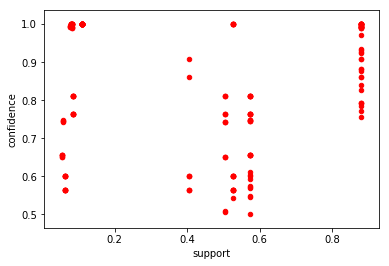

In [122]:
df.plot(kind='scatter',x='support',y='confidence',color='r')
plt.show()